In [1]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3907845696789668488
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5748293632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13100701304628364326
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import os 
import io
import zipfile
from zipfile import ZipFile
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import scipy 
import PIL
import requests
from glob import glob

In [3]:
pwd

'C:\\Users\\Junseok\\Desktop'

In [4]:
cd C:\Users\Junseok\Desktop\7가지_감정_표정_데이터

C:\Users\Junseok\Desktop\7가지_감정_표정_데이터


In [5]:
pwd

'C:\\Users\\Junseok\\Desktop\\7가지_감정_표정_데이터'

In [6]:
ls ./ -R

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: E680-AAA0

 C:\Users\Junseok\Desktop\7가지_감정_표정_데이터 디렉터리

2022-12-04  오후 07:56    <DIR>          .
2022-12-04  오후 07:56    <DIR>          ..
2022-12-04  오후 07:56        35,036,008 best_mask_model.h5
2022-12-04  오후 06:13    <DIR>          기쁨
2022-12-04  오후 06:13    <DIR>          당황
2022-12-04  오후 06:13    <DIR>          분노
2022-12-04  오후 06:13    <DIR>          불안
2022-12-04  오후 06:13    <DIR>          상처
2022-12-04  오후 06:13    <DIR>          슬픔
2022-12-04  오후 06:13    <DIR>          중립
               1개 파일          35,036,008 바이트
               9개 디렉터리  248,573,100,032 바이트 남음


In [41]:
label = os.listdir()
label

['기쁨', '당황', '분노', '불안', '상처', '슬픔', '중립']

In [8]:
base_dir = 'C:/Users/Junseok/Desktop/7가지_감정_표정_데이터'
base_dir = os.path.join(base_dir)
base_dir

'C:/Users/Junseok/Desktop/7가지_감정_표정_데이터'

In [9]:
count = len(list(glob('./*/*.jpg')))
print(count)

2090


In [10]:
happy = list(glob('기쁨/*.jpg'))
panic = list(glob('당황/*.jpg'))
anger = list(glob('분노/*.jpg'))
worry = list(glob('불안/*.jpg'))
hurt = list(glob('상처/*.jpg'))
sad = list(glob('슬픔/*.jpg'))
blank = list(glob('중립/*.jpg')) 

In [11]:
print(len(happy), len(panic), len(anger), len(worry), len(hurt), len(sad), len(blank))

297 298 299 298 299 299 300


(760, 616, 3)


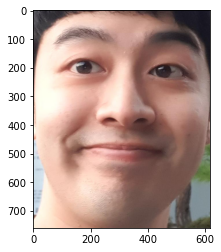

In [12]:
img = PIL.Image.open(str(happy[0]))
imgArr = np.array(img)
print(imgArr.shape)
plt.imshow(img)

In [13]:
batch_size = 32
img_height = 400
img_width = 500

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  color_mode = 'rgb',
  seed=123,
  image_size=(img_height, img_width),
  shuffle = True,
  batch_size=batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  color_mode = 'rgb',
  seed=123,
  image_size=(img_height, img_width),
  shuffle = True,
  batch_size=batch_size)

Found 2100 files belonging to 7 classes.
Using 1680 files for training.
Found 2100 files belonging to 7 classes.
Using 420 files for validation.


In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#이미지 제너레이터 정의
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=25,
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest'
                                  ) 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_acc', patience=7,verbose=1)
mc = ModelCheckpoint('best_mask_model.h5',
                     monitor='val_acc',
                     verbose=2, save_best_only = True)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2,l1,l1_l2

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same',
                 activation = 'relu', input_shape = (400, 500, 3)))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same',
                 activation = 'relu')) 
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same'))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])
with tf.device('/device:GPU:0'):
    history = model.fit(train_dataset,
            epochs = 100,
            validation_data = val_dataset,
           callbacks=[es,mc])

Epoch 1/100
53/53 [==============================] - ETA: 0s - loss: 72.6281 - acc: 0.1381
Epoch 1: val_acc did not improve from 0.25476
53/53 [==============================] - 12s 212ms/step - loss: 72.6281 - acc: 0.1381 - val_loss: 1.9472 - val_acc: 0.1476
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 1.9385 - acc: 0.1613
Epoch 2: val_acc did not improve from 0.25476
53/53 [==============================] - 11s 209ms/step - loss: 1.9385 - acc: 0.1613 - val_loss: 1.9507 - val_acc: 0.1286
Epoch 3/100
53/53 [==============================] - ETA: 0s - loss: 1.8993 - acc: 0.1964
Epoch 3: val_acc did not improve from 0.25476
53/53 [==============================] - 11s 210ms/step - loss: 1.8993 - acc: 0.1964 - val_loss: 1.9719 - val_acc: 0.1452
Epoch 4/100
53/53 [==============================] - ETA: 0s - loss: 1.7867 - acc: 0.2881
Epoch 4: val_acc did not improve from 0.25476
53/53 [==============================] - 11s 208ms/step - loss: 1.7867 - acc: 0.2881 - v

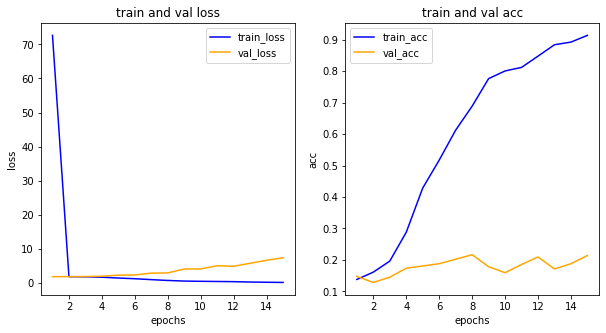

In [21]:
# 학습결과 시각화

import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize = (10,5))

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss , color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

(675, 700, 3)


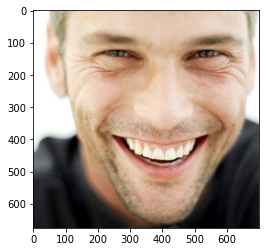

In [97]:
img = PIL.Image.open(("C:/Users/Junseok/Desktop/test_happy.jpg"))
imgArr = np.array(img)
print(imgArr.shape)
plt.imshow(img)

In [95]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

def pred(fname):
    img = PIL.Image.open((fname))
    img = img.resize((int(500), int(400)))
    plt.imshow(img)

    x=np.array(img)
    images = np.expand_dims(x, axis = 0)
    classes = model.predict(images, batch_size = 10)
    index = np.argmax(classes[0])
    print('이 표정은 ' + label[index]+'입니다.')


1/1 [==============================] - 0s 14ms/step
이 표정은 당황입니다.


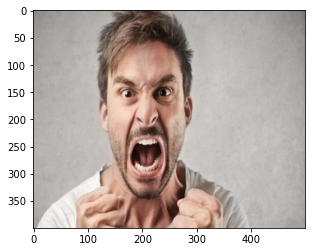

In [96]:
pred("C:/Users/Junseok/Desktop/분노_test.jpg")

In [81]:
model.save('model.h5')